<center> <font size="6"> Rapidly Measuring Spatial Accessibility of COVID-19 Healthcare Resources: A Case Study of Illinois, USA </font> </center>
<br>

<font size="3"> **Author**: Jeon-Young Kang <sup>1,2</sup>, Alexander Michels <sup>1,3</sup>, Fanzheng Lyu<sup>1,2</sup>, Shaohua Wang<sup>1,2 </sup>, Nelson Agbodo<sup>4</sup>, Vincent Freeman<sup>5</sup>, Shaowen Wang<sup>1,2,3,* </sup> </font>
<br>

<font size="3"> <sup> 1 </sup> CyberGIS Center for Advanced Digital and Spatial Studies, University of Illinois at UrbanaChampaign, Urbana, Illinois </font> <br>
<font size="3"> <sup> 2 </sup> Department of Geography and Geographic Information Science, University of Illinois at Urbana-Champaign, Urbana, Illinois <br>
<font size="3"> <sup> 3 </sup>Illinois Informatics Institute, University of Illinois at Urbana-Champaign, Urbana, Illinois <br>
<font size="3"> <sup> 4 </sup> Division of Health Data and Policy, Illinois Department of Public Health, Springfield, Illinois <br>
<font size="3"> <sup> 5 </sup> Division of Epidemiology and Biostatistics, School of Public Health, University of Illinois at Chicago, Chicago, Illinois <br> <br>
<font size="3"> <sup> * </sup> Corresponding author: shaowen@illinois.edu <br>

[CyberGIS Center for Advanced Digital and Spatial Studies](https://cybergis.illinois.edu/) <br /><br />
[CyberInfrastructure & Geospatial Information Laboratory](https://cigi.illinois.edu/) <br /><br />
### The accessibility measure calculated here is updated daily on https://wherecovid19.cigi.illinois.edu/
### You can checkout the paper here: https://doi.org/10.1186/s12942-020-00229-x


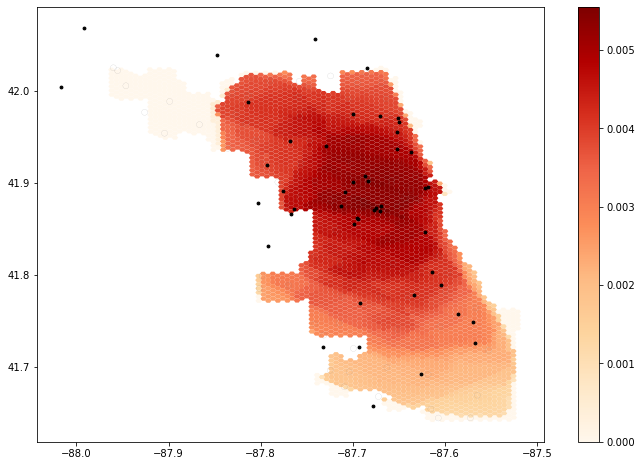

### Reference
Kang, J. Y., Michels, A. C., Lyu, F., Wang, S., Agbodo, N., Freeman, V. L., & Wang, S. (2020). Rapidly Measuring Spatial Accessibility of COVID-19 Healthcare Resources: A Case Study of Illinois, USA. medRxiv https://doi.org/10.1101/2020.05.06.20093534


### Objectives
This aims to measure spatial access for people to hospitals in Illinois. The spatial accessibiilty is measured by the use of an enhanced two-step floating catchment area (E2FCA) method (Luo & Qi, 2009), which is an outcome of interactions between demands (i.e, # of potential patients; people) and supply (i.e., # of beds or physicians). As a result, the map of spatial accessibility will be produced. It identifies which regions need more healthcare resources, such as the number of beds or physicians. This notebook would serve as a guideline of which regions need more beds for fighting against COVID-19.  

### Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hosptial information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Method - An enhanced two-step floating catchment area (E2FCA)

The catchement area for each hospital will be delineated by travel times. People living in the overlappying regions by multiple hospitals' catchment area are more accessible to hospitals than people living in other places. 

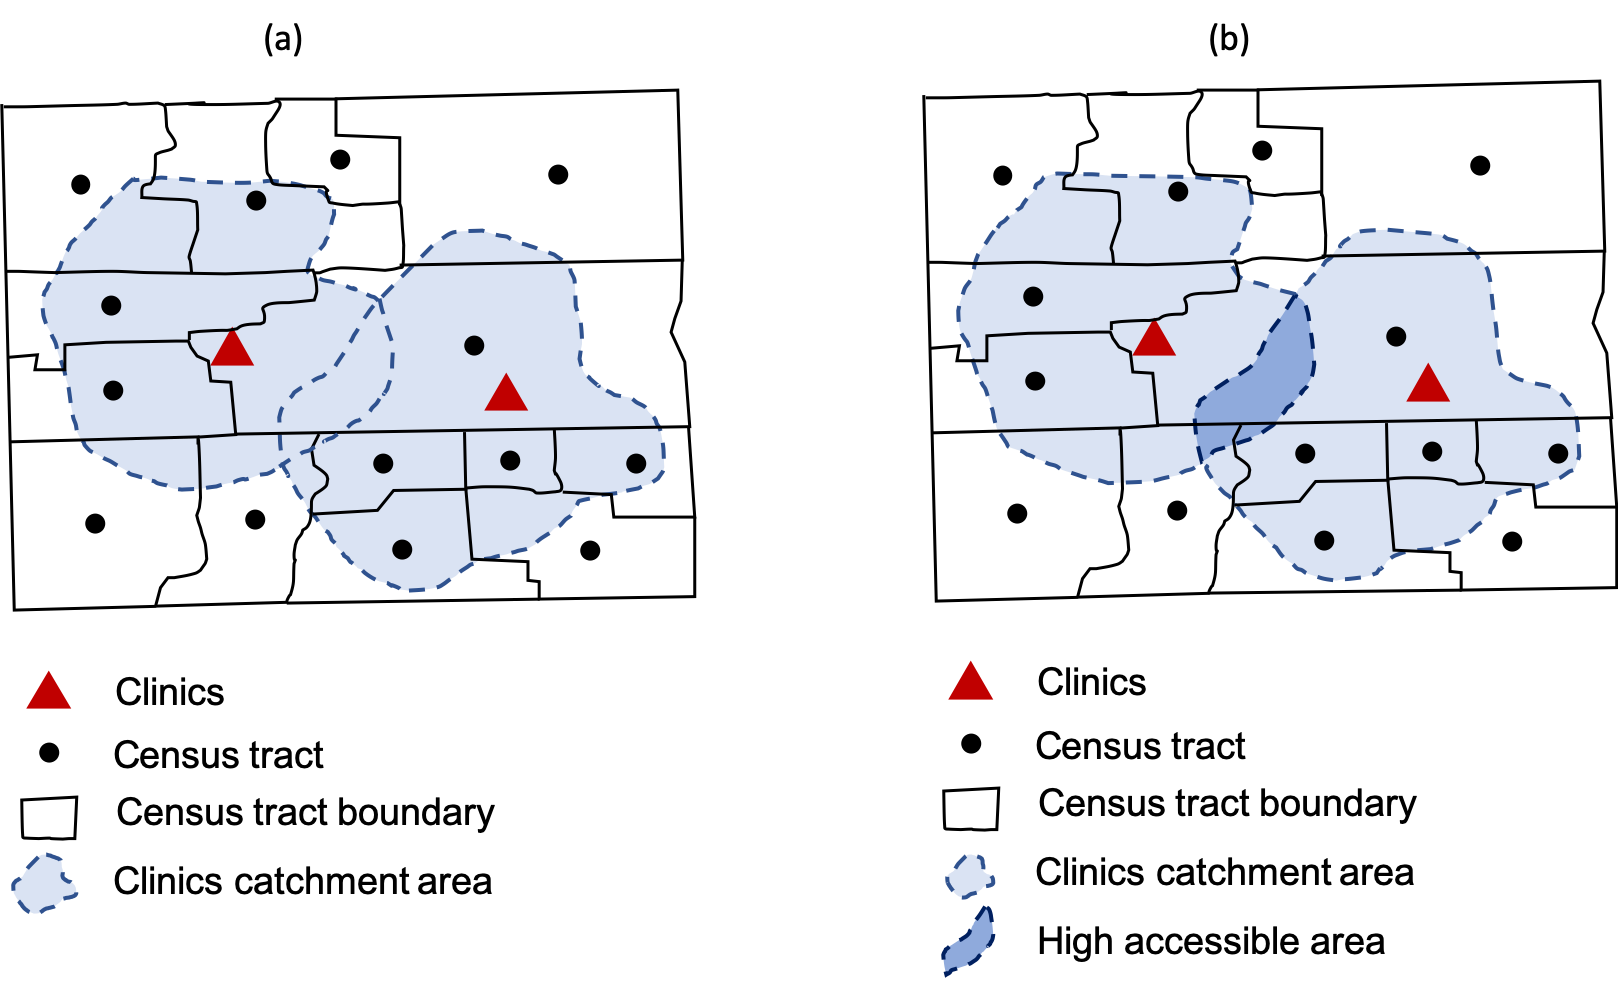


### Codes
Import necessary libraries to run this model.
See `requirements.txt` for the library versions used for this analysis.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium, itertools, os, time, warnings
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")

## Load and Visualize Data

### Population and COVID-19 Cases Data by County

In [ ]:
pop_data = gpd.read_file('./data/PopData/Chicago_Tract.shp')
pop_data.head()

### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [ ]:
hospitals = gpd.read_file('./data/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

### Generate and Plot Map of Hospitals

In [ ]:
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='grey',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grids (500-meter resolution)

In [ ]:
grid_file = gpd.read_file('./data/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Load and Plot the Street Network

In [ ]:
if not os.path.exists("data/Chicago_Network.graphml"):
    G = ox.graph_from_place('Chicago', network_type='drive') # pulling the drive network the first time will take a while
    ox.save_graphml(G, 'Chicago_Network.graphml')
else:
    G = ox.load_graphml('Chicago_Network.graphml', node_type=str)
ox.plot_graph(G)

## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### network_setting

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [ ]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                if len(data['maxspeed'].split(','))==2:
                    data['maxspeed']=float(data['maxspeed'].split(',')[0])                  
                elif data['maxspeed']=='signals':
                    data['maxspeed']=35.0 # drive speed setting as 35 miles
                else:
                    data['maxspeed']=float(data['maxspeed'].split()[0])
            else:
                data['maxspeed']=float(data['maxspeed'][0].split()[0])
        else:
            data['maxspeed']= 35.0 #miles
        data['maxspeed_meters'] = data['maxspeed']*26.8223 # convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))    
    return(network)

### hospital_setting

Finds the nearest OSMNX node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest OSMNX node

In [ ]:
def hospital_setting(hospitals, G):
    hospitals['nearest_osm']=None
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [ ]:
# to estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### calculate_catchment_area

Calculates a catchment area of things within some distance of a point using a given metric.

Function first creates an ego-centric subgraph on the NetworkX road network starting with the nearest OSM node for the hospital and going out to a given distance as measured by the distance unit. We then calculate the convex hull around the nodes in the ego-centric subgraph and make it a GeoPandas object.

Args:

* G: OSMNX network
* nearest_osm: OSMNX road network node that is closest to the place of interest (hospital)
* distance: the max distance to include in the catchment area
* distance_unit: how we measure distance (used by ego_graph), we always use time

Returns:

* GeoDataFrame the catchment area.

In [ ]:
def calculate_catchment_area(G, nearest_osm, distance, distance_unit = "time"):
    road_network = nx.ego_graph(G, nearest_osm, distance, distance=distance_unit) 
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

### hospital_measure_acc

Measures the effect of a single hospital on the surrounding area. (Uses `calculate_catchment_area`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [ ]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    ##distance weight = 1, 0.68, 0.22
    polygons = []
    for distance in distances:
        polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
        
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # to exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('\rCatchment for hospital {:4.0f} complete'.format(_thread_id), end="")
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ])

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [ ]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [ ]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [ ]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [ ]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

### file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [ ]:
def file_import (pop_type, region):
    if not os.path.exists("./Data/{}_Network.graphml".format(region)):
        G = ox.graph_from_place(region, network_type='drive') # pulling the drive network the first time will take a while
        ox.save_graphml(G, './Data/{}_Network.graphml'.format(region))
    #G = ox.load_graphml('./Data/{}_Network.graphml'.format(region), node_type=str)
    G = ox.load_graphml('./Data/Illinois_Network.graphml', node_type=str)
    hospitals = gpd.read_file('./Data/HospitalData/{}_Hospital_Info.shp'.format(region))
    grid_file = gpd.read_file('./Data/GridFile/{}_Grid.shp'.format(region))
    if pop_type=="pop":
        pop_data = gpd.read_file('./Data/PopData/{}_Tract.shp'.format(region))
    if pop_type=="covid":
        pop_data = gpd.read_file('./Data/PopData/{}_ZIPCODE.shp'.format(region))
    return G, hospitals, grid_file, pop_data

In [ ]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='OrRd',figsize=(18,12), legend=True, zorder=1)
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    ax.scatter(hospitals.X, hospitals.Y, zorder=1, c='black', s=8)

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest

In [ ]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 4, description = "Processor: ")

place_dropdown = ipywidgets.Dropdown( options=[("Chicago", "Chicago"), ("Illinois","Illinois")],
    value = "Chicago", description = "Region: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "hospital_icu_beds"), ("Ventilators", "hospital_vents") ],
    value = "hospital_icu_beds", description = "Resource: ")
display(processor_dropdown,place_dropdown,population_dropdown,resource_dropdown)

In [ ]:
# G, hospitals, grid_file, pop_data = file_import (population_dropdown.value, place_dropdown.value)
G = network_setting (G)
pop_data = pop_centroid(pop_data, population_dropdown.value)
hospitals = hospital_setting(hospitals, G)
distances=[10,20,30] # distances in travel time
weights=[1.0, 0.68, 0.22] # weights where weights[0] is applied to distances[0]
resources = ["hospital_icu_beds", "hospital_vents"] # resources

In [ ]:
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)

In [ ]:
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result=overlapping_function (grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

In [ ]:
result.head()

In [ ]:
result = normalization (result, resource_dropdown.value)

### Visualization & Conclusion

The black dots represent hospitals. People living in the darker-colored regions are more accessible to the hospitals than those living in the lighter-colored regions. To cope with this health inequality issue, policy makers need to consider about placing more hospitals in the ligher-colored regions. This can also be applicable to COVID-19. To be more specific, people living in southern Chicago are less accessible to get tested and to be hospitalized, under assumption that people are more likely to visit to the nearby hospitals from their home. 

In [ ]:
result = result.to_crs({'init': 'epsg:4326'})
output_map(result, pop_data, hospitals, resource_dropdown.value)

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.